Case Retrieval
===


This notebook contains the implementation of the case retrieval that is presented in the paper

In [57]:
#export
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *

from mppn.mppn import *

## Pre-training

This section pretraines the MPPN neural network on the Mobis dataset

In [4]:
log=import_log(EventLogs.Mobis)

In [14]:
splits=split_traces(log)

In [5]:
log

,event_id,activity,type,user,cost,timestamp,resource
trace_id,,,,,,,
1,0,pay expenses_start,Accounting,FI12,167.52,2017-01-16 12:29:00+00:00,FI12
1,1,pay expenses_complete,Accounting,FI12,167.52,2017-01-16 12:40:00+00:00,FI12
5,0,pay expenses_start,Accounting,JH2172,262.11,2017-01-16 07:38:00+00:00,JH2172
5,1,pay expenses_complete,Accounting,JH2172,262.11,2017-01-16 07:48:00+00:00,JH2172
6,0,calculate payments_start,Accounting,WE5108,413.14,2017-01-04 05:59:00+00:00,WE5108
...,...,...,...,...,...,...,...
7268,1,file travel request_complete,Employee,RT4514,458.31,2017-12-29 18:54:00+00:00,RT4514
7268,2,check if travel request needs preliminary price inquiry_start,NaN,NaN,NaN,2017-12-29 18:54:00+00:00,NOT_SET
7268,3,check if travel request needs preliminary price inquiry_complete,NaN,NaN,NaN,2017-12-29 18:56:00+00:00,NOT_SET


In [75]:
MinMax??

In [41]:
def fill_missing(o):
    for c in o.cont_names: o.items[c].fillna(0.0,inplace=True)

In [42]:
o=PPObj(log,[Categorify,MinMax,Datetify,fill_missing],
        cat_names=['activity','type','resource'],
        cont_names=['cost'],date_names=['timestamp'],
        splits=splits, y_names=['activity','resource','timestamp_Relative_elapsed_minmax']
       )

In [51]:
o.cont_names

(#5) ['activity_minmax','type_minmax','resource_minmax','cost_minmax','timestamp_Relative_elapsed_minmax']

In [45]:
o.ys

,activity,resource,timestamp_Relative_elapsed_minmax
trace_id,,,
6823,32,320,0.000000
6823,31,320,0.000027
6823,16,186,0.000027
6823,15,186,0.000027
6823,24,186,0.000027
...,...,...,...
2051,3,69,0.484132
2051,44,169,0.504250
2051,43,169,0.504327


In [69]:
dls=o.get_dls(after_batch=gaf_transform,bs=512)

In [70]:
xb,yb=dls.one_batch()

In [71]:
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)

In [72]:
output_attr=mppn_get_output_attributes(o)
m=mppn_representation_learning_model(False,len(o.cont_names),output_attr)

Loading Alexnet to train MPPNs CNN from scratch


In [73]:
p=m(xb.cpu())
loss(p,yb)


TensorBase(10.6659, grad_fn=<AliasBackward>)

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,6.840597,5.375869,0.660812,0.242301,16.352974,00:39
1,3.768782,3.400568,0.915848,0.337939,11.105602,00:39
2,2.913498,2.760426,0.925254,0.385051,9.374220,00:39
3,2.611883,2.520039,0.928583,0.412352,8.759467,00:39
4,2.411653,2.348461,0.933078,0.421591,7.880533,00:38
5,2.264779,2.231918,0.940736,0.430331,8.500729,00:38
6,2.157140,2.170682,0.941735,0.447478,8.036813,00:38
7,2.052971,2.108578,0.940403,0.459131,6.154808,00:37
8,1.958620,2.025480,0.940153,0.467205,5.583508,00:37
9,1.892552,1.985206,0.942234,0.476694,7.690752,00:37


Better model found at epoch 0 with valid_loss value: 5.375869274139404.
Better model found at epoch 1 with valid_loss value: 3.4005682468414307.
Better model found at epoch 2 with valid_loss value: 2.760425567626953.
Better model found at epoch 3 with valid_loss value: 2.5200388431549072.
Better model found at epoch 4 with valid_loss value: 2.3484609127044678.
Better model found at epoch 5 with valid_loss value: 2.2319183349609375.
Better model found at epoch 6 with valid_loss value: 2.170681953430176.
Better model found at epoch 7 with valid_loss value: 2.1085777282714844.
Better model found at epoch 8 with valid_loss value: 2.025479793548584.
Better model found at epoch 9 with valid_loss value: 1.9852063655853271.
Better model found at epoch 10 with valid_loss value: 1.9794319868087769.
Better model found at epoch 11 with valid_loss value: 1.9229627847671509.
Better model found at epoch 12 with valid_loss value: 1.9144351482391357.
Better model found at epoch 13 with valid_loss value

Better model found at epoch 0 with valid_loss value: 0.9452365040779114.


0.9452365040779114

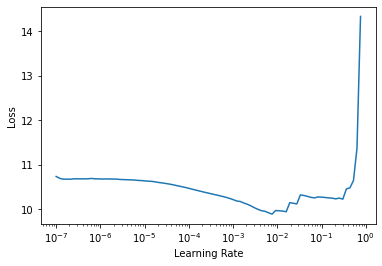

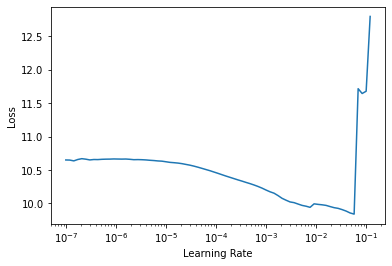

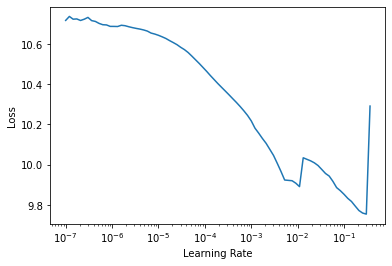

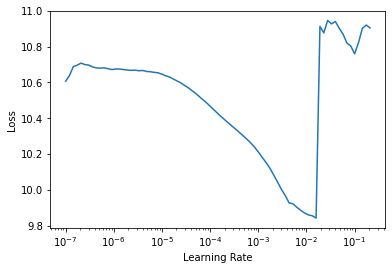

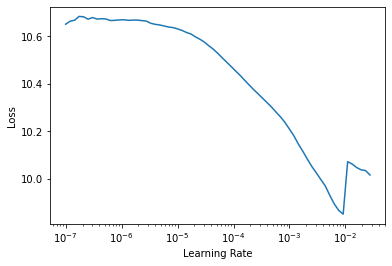

In [74]:
train_validate(dls,m,loss=loss,metrics=metrics,epoch=20,model_name='Case_retrieval_mppn')

In [127]:
subsequences_fast??

In [129]:
def trace_sequence(df,event_ids=None):
    l=[]
    idx=[]
    for i,c in df.groupby(level=0):
        a=c.to_numpy()
        npad = ((64-len(a), 0), (0, 0))
        a=np.pad(a,pad_width=npad).T
        idx.append(i)
        l.append(a)    
    return np.stack(l),idx

In [130]:
ws,idx=trace_sequence(o.xs)

In [154]:
from pyts.image import GramianAngularField
from PIL import Image

In [155]:
def _gaf_loop(e,transformer):
        inp,y=e
        inp[inp>1]=1
        inp[inp<0]=0
        inp=inp*2-1
        x=torch.stack(
            tuple(_gaf_attr(inp[:,i],transformer) for i in range(inp.shape[1]))
        ).transpose(0,1)
        x=x[:,:,None].expand(-1,-1,3,-1,-1)
        return x,y

def _gaf_attr(x,transformer):
    try:

        x = transformer.transform(x)
    except ValueError as e:
        print(x)
        raise e
    x=tensor(x)
    x = x * 255
    return x



class gaf_transform(ItemTransform):
    ''' GAF transormation: converts a bash into a gramian angular field and reshapes it to RGB'''
    def __init__(self,gs=64):
        self.transformer=GramianAngularField(image_size=gs,sample_range=None, method="s", overlapping=True)

    def encodes(self,e): return _gaf_loop(e,self.transformer)

In [156]:
gt=gaf_transform()

In [157]:
x_all,_=gt((ws,None))

In [162]:
del m.heads

In [171]:
m_fv = BaseMPPN(5, 64, 128)
m_fv.CNN = m.CNN
m_fv.MLP = m.MLP
m_fv

BaseMPPN(
  (CNN): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (MLP): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=320, out_features=160, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=160, out_features=128, bias=True)
  )
)

In [202]:
res=m_fv.cpu()(x_all).detach().numpy()

In [235]:
fvs = [fv[0] for fv in res]

In [243]:
pd_cases_fv = pd.DataFrame({})
pd_cases_fv["case_id"] = idx
pd_cases_fv["fv"] = fvs

## Visualization

For the visualization of the representation space we use reduce it with sklearn's PCA and than vizualize it as a scatter plot.

In [245]:
from sklearn.decomposition import PCA

In [246]:
fv_matrix = np.array(pd_cases_fv["fv"].tolist())

In [247]:
pca_model = PCA(n_components=2, random_state=1111)
pca_rep = pca_model.fit_transform(fv_matrix)

In [248]:
pca_df = pd.DataFrame(data={"x": pca_rep[:, 0],
                           "y": pca_rep[:, 1],
                           "case_id": pd_cases_fv["case_id"].tolist()})

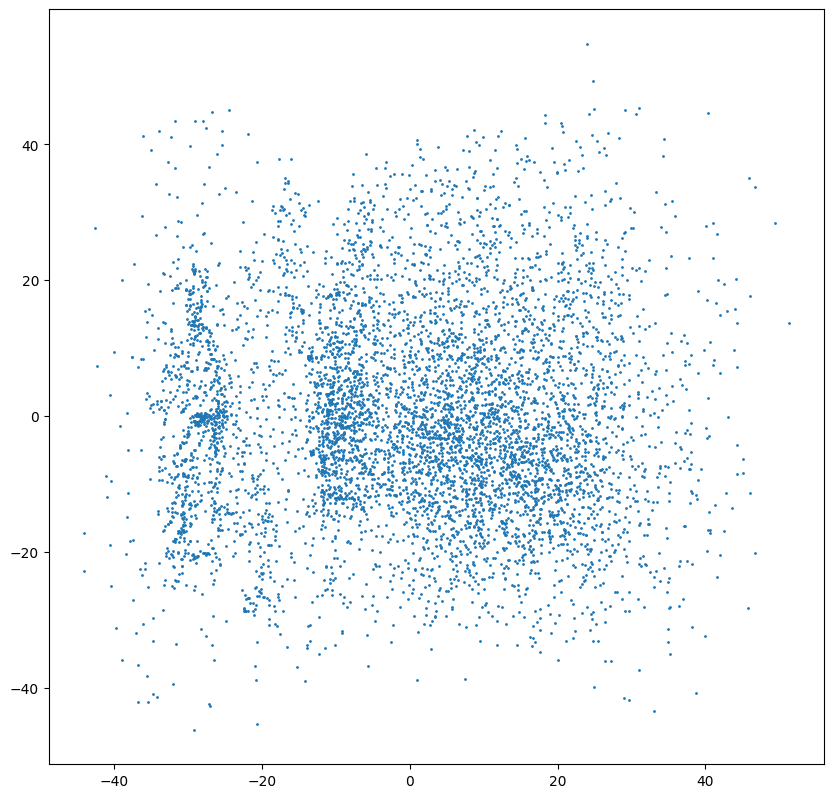

In [249]:
plt.figure(figsize=(10, 10), dpi=100)
scatterplot = plt.scatter(pca_df["x"], pca_df["y"], s=1)

## Case Retrieval

The case retrieval is implemented by calculating the pairwise similarity between the cases first. As metric the euclidean distance is used.

In [250]:
from scipy import spatial

def compute_similarities(pd_cases_fv):
    pd_cases_fv["most_similar_cases"] = pd.NA
    for idx, case in pd_cases_fv.iterrows():
        pd_cases_fv.at[idx, "most_similar_cases"] = compute_trace_retrieval_order(case["fv"], pd_cases_fv["fv"])
    
    return pd_cases_fv

def compute_trace_retrieval_order(case_fv, all_fv):
    
    cases_fv = np.array(case_fv.reshape(1, -1))
    all_fv = np.array(all_fv.tolist()).reshape(len(all_fv), case_fv.shape[-1])
    
    fv_distances = spatial.distance.cdist(cases_fv, all_fv, metric="cosine").reshape(-1)
    
    return np.argsort(fv_distances).tolist()

def retrieve_most_similar_cases(pd_cases_fv, case_id, top_n=5):
    
    query_case = pd_cases_fv[pd_cases_fv["case_id"] == case_id]
    
    most_similar_cases_idx = query_case["most_similar_cases"].tolist()[0][1:top_n+1]
    
    return most_similar_cases_idx

In [251]:
pd_cases_fv = compute_similarities(pd_cases_fv)

In [253]:
retrieve_most_similar_cases(pd_cases_fv, 5523, top_n=5)

[4696, 4710, 5501, 5903, 5551]